In [1]:
import numpy as np
import obspy
from hydrophone_data_processing import load, useful_variables, plotting, signal_processing
import scipy.signal as signal
import pandas as pd
import matplotlib.dates as dates
import obspy.signal.trigger as trigger
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import config
from event_pipeline import Event
from obspy.imaging.spectrogram import spectrogram


def import_data(day, starttime, endtime):
    daypaths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=day)
    starttime = obspy.UTCDateTime(starttime)
    endtime = obspy.UTCDateTime(endtime)
    data = load.import_corrected_data_for_single_day(daypaths)
    data.trim(starttime=starttime, endtime=endtime)
    return data

In [2]:
day141 = import_data(day=141, starttime='2019-05-21T07:00:00.0Z', endtime='2019-05-21T09:00:00.0Z')

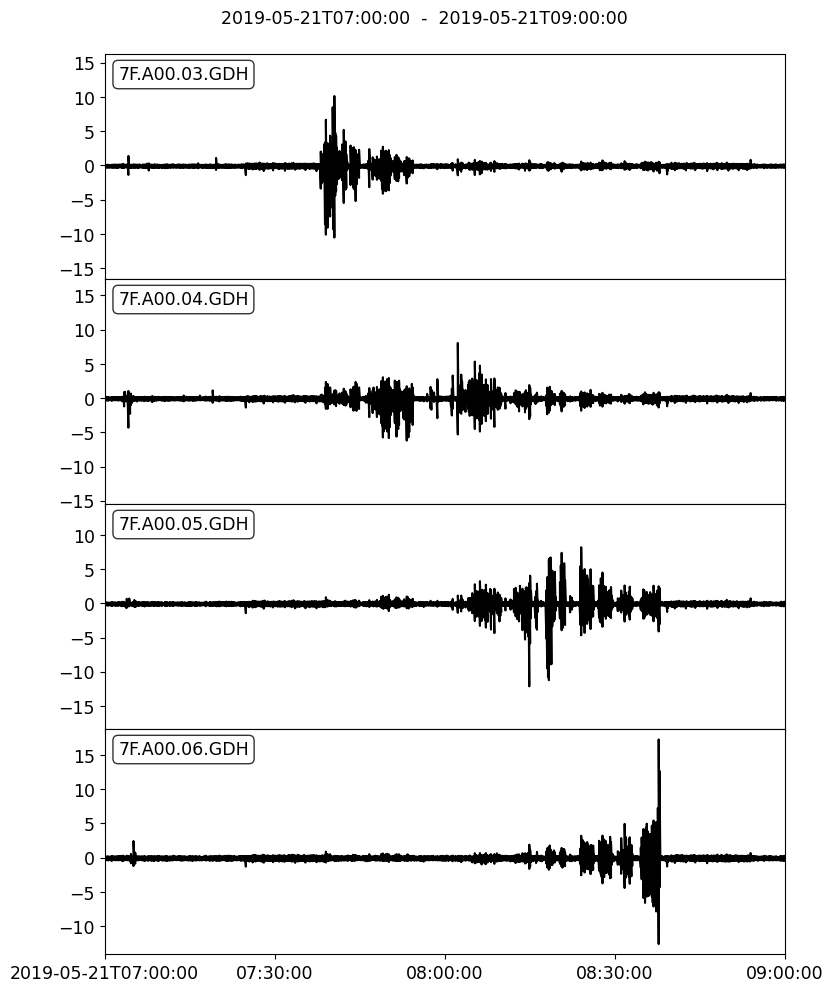

In [8]:
x = day141[2:].plot()

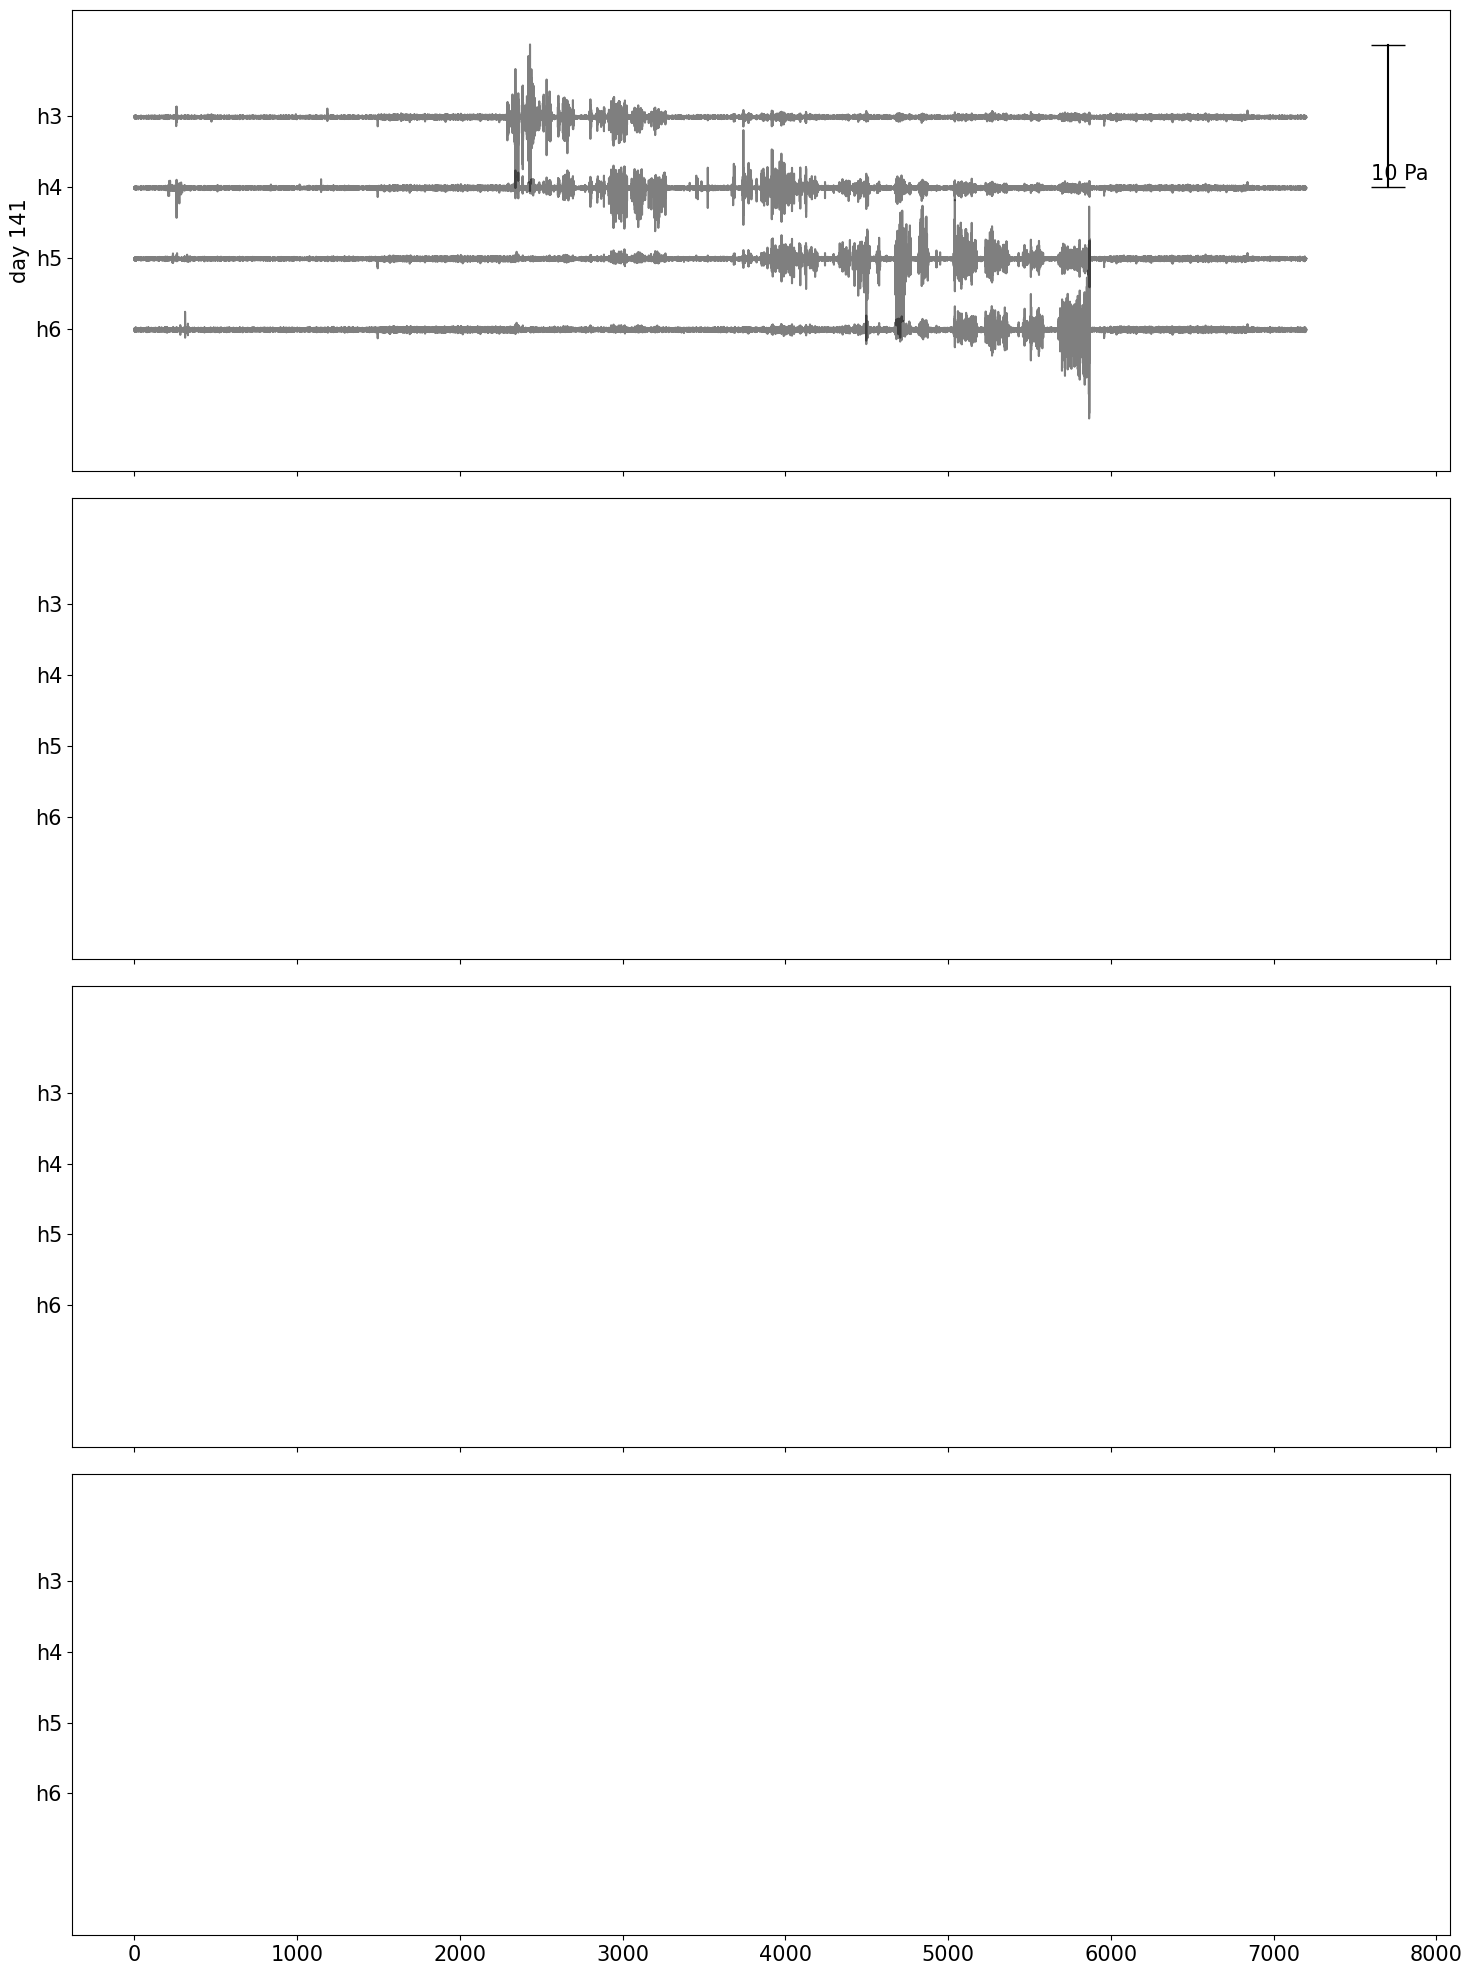

In [7]:
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(4, 1, figsize=(15, 20), sharey=True, sharex=True)

def plot_waveform(ax, stream, day):
    times = np.array([tr.times() for tr in stream][2:])
    data = [tr.data for tr in stream][2:]
    n = 0
    # ax.set_yticklabels(['h3', 'h4', 'h5', 'h6'], fontsize=15)
    for t, d in zip(times, data):
        ax.plot(t, d - n * 10, color='black', alpha=0.5)
        if n == 0:
            ax.plot((t.max()+500, t.max()+500), (-10, 10), marker='_', markersize=25, color='black')
            ax.text(s='10 Pa', x=t.max()+400, y=-9)
        n+=1
        
    ax.set_ylabel('day ' + str(day))

plot_waveform(ax=ax[0], stream=day141, day=141)
# plot_waveform(ax=ax[1], stream=day188, day=188)
# plot_waveform(ax=ax[2], stream=day197, day=197)
# plot_waveform(ax=ax[3], stream=day211, day=211)

ax[0].set_ylim(-50, 15)
ax[0].set_yticks([0, -10, -20, -30])
ax[0].set_yticklabels(['h3', 'h4', 'h5', 'h6'])

plt.tight_layout()

# fig.savefig('figures/raw_waveforms.pdf', bbox_inches='tight')

decided not to use this one


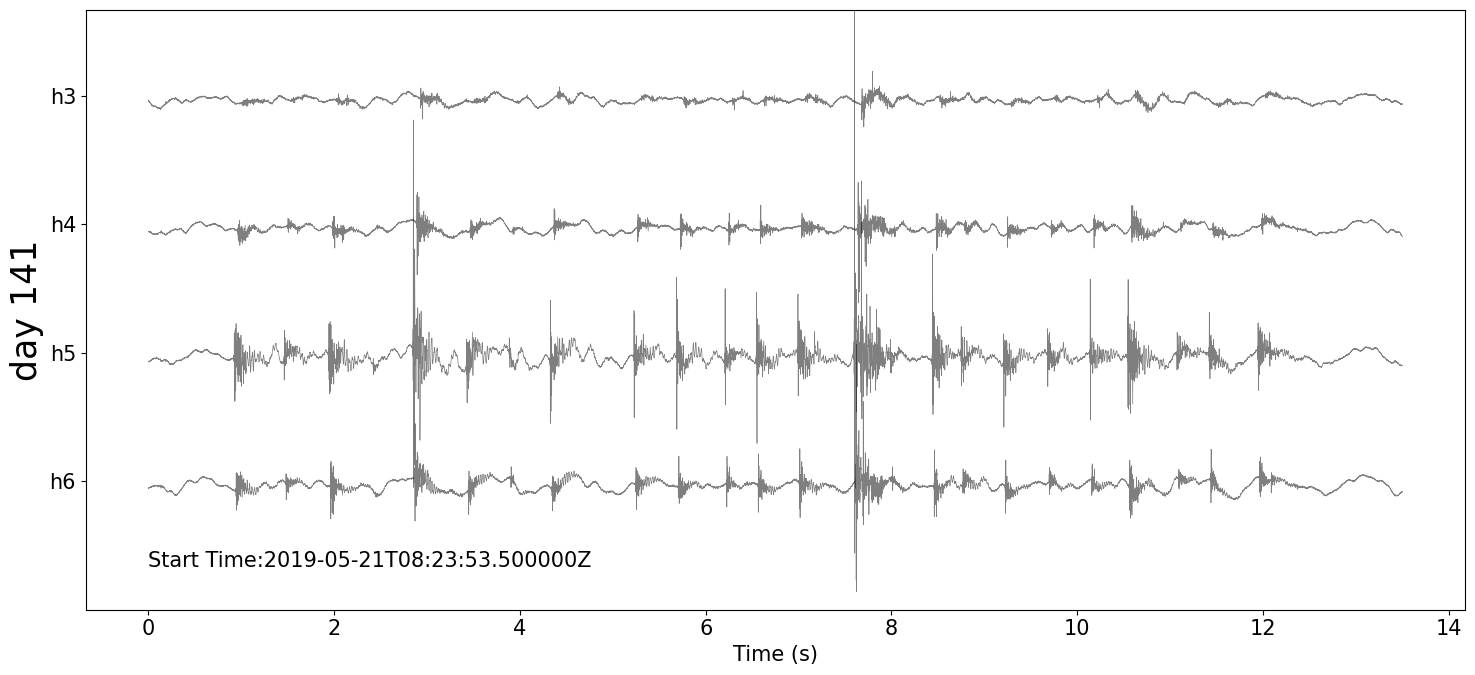

In [26]:
def plot_waveform(ax, stream, day):
    times = np.array([tr.times() for tr in stream][2:])
    data = [tr.data for tr in stream][2:]
    n = 0
    for t, d in zip(times, data):
        ax.plot(t, d - n * 3, color='black', linewidth=0.5, alpha=0.5)
        n+=1
        
    ax.set_ylabel('day ' + str(day), fontsize=25)

fig, ax = plt.subplots(figsize=(15, 7))
starttime = obspy.UTCDateTime('2019-05-21T08:23:53.500000Z')
endtime = obspy.UTCDateTime('2019-05-21T08:24:07.000000Z')
plot_waveform(ax=ax, stream=day141.copy().trim(starttime, endtime), day=141)
ax.set_ylim(-12, 2)
ax.set_yticks(np.array([0, -1, -2, -3])*3)
ax.set_yticklabels(['h3', 'h4', 'h5', 'h6'], fontsize=15)
ax.set_xlabel('Time (s)', fontsize=15)
ax.text(s=f'Start Time:{starttime}', x=0, y=-11, fontsize=15)
fig.tight_layout()
# fig.savefig('figures/zoom_swarm.pdf', bbox_inches='tight')
print('decided not to use this one')

In [27]:

def import_catalog(file):
    df = pd.read_csv(file)
    df.sort_values(by='first_arrival', inplace=True)
    df['arrival_datetime'] = df.arrival_time.apply(dates.num2date)
    return df

def plot_depths(df, cmap, day):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.scatter(df.arrival_datetime, df.depth, marker='.', linewidth=0, c=df.first_hydrophone, cmap=cmap)
    ax.set_ylabel('day '+str(day), fontsize=25)
    ax.set_ylim(400, 50)
    return fig, ax

In [28]:
df141 = import_catalog(file='141precision.csv')


In [29]:
# also need to remove a number of columns that are simply irrelevant to the analysis or untested for a shareable dataset.

columns_to_keep = ['id', 'depth', 'relative_depth',
        'first_hydrophone', 'second_hydrophone',
       'arrival_time', 'first_arrival', 'second_arrival', 'dt',
       'max_amp', 'cum_amp', 'arrival_datetime', 'origin_time']

df141 = df141[columns_to_keep].copy()
# df188 = df188[columns_to_keep].copy()
# df197 = df197[columns_to_keep].copy()
# df211 = df211[columns_to_keep].copy()

df141.sort_values(by='arrival_datetime', inplace=True)
# df188.sort_values(by='arrival_datetime', inplace=True)
# df197.sort_values(by='arrival_datetime', inplace=True)
# df211.sort_values(by='arrival_datetime', inplace=True)

# # removing the events with maximum amplitude <0.1 since they are false positives
df141 = df141[df141.max_amp > 0.1].copy()
# df188 = df188[df188.max_amp > 0.1].copy()
# df197 = df197[df197.max_amp > 0.1].copy()
# df211 = df211[df211.max_amp > 0.1].copy()

df141.drop_duplicates(subset=['arrival_datetime',], inplace=True)
# df188.drop_duplicates(subset=['arrival_datetime',], inplace=True)
# df197.drop_duplicates(subset=['arrival_datetime',], inplace=True)
# df211.drop_duplicates(subset=['arrival_datetime',], inplace=True)

In [30]:
print('length of day 141 swarm in seconds:', pd.Timedelta(np.array(df141.arrival_datetime.tail(1).values - df141['arrival_datetime'].head(1).values)[0]).total_seconds())

length of day 141 swarm in seconds: 3545.596


In [31]:
print('day141 N-events:', df141.shape)
# print('day188 N-events:', df188.shape)
# print('day197 N-events:', df197.shape)
# print('day211 N-events:', df211.shape)

day141 N-events: (1931, 13)


In [32]:
def get_swarm_time_length(df):
    start = df.head(1).arrival_datetime.values
    end = df.tail(1).arrival_datetime.values
    tl = (end - start)/np.timedelta64(1, 's')
    return tl[0]
print('Day 141 event length:', get_swarm_time_length(df141))
# print('Day 188 event length:', get_swarm_time_length(df188))
# print('Day 197 event length:', get_swarm_time_length(df197))
# print('Day 211 event length:', get_swarm_time_length(df211))

Day 141 event length: 3545.596


In [51]:
from event_pipeline import Event
import torchaudio.transforms as T
import librosa
import torch

import matplotlib.dates as mdates
import datetime


def get_event(event_id, day_number, df, hanning=True):
    paths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=day_number)
    waveforms = load.import_corrected_data_for_single_day(paths=paths)
    df = df.copy()
    e = Event(id=event_id
              , starttime=df.arrival_time.loc[event_id]
              , init_first_hphone=df.first_hydrophone
              , waveforms=waveforms
              , hanning=hanning
             )
    return e

def get_times(event):
    trace = event.stream[event.first_hydrophone_id]
    times = trace.times()
    times_len = times.shape[0]
    return np.arange(0, times_len, 1)

def plot_spectrogram(event, ax):
    trace = event.stream[event.first_hydrophone_id]
    torch_data = torch.from_numpy(trace.data)
    spectrogram = T.Spectrogram(n_fft=2**6, hop_length=1)
    spec = spectrogram(torch_data)
    ax.imshow(librosa.power_to_db(spec), origin='lower', aspect='auto', cmap='gist_rainbow')
    

def plot_50hz_highpass(event, ax):
    trace = event.stream[event.first_hydrophone_id].copy()
    times = get_times(event=event)
    tr = trace.filter(type='highpass', freq=50)
    ax.plot(times, tr.data, color='violet', label='50Hz highpass'
            ,linewidth=2)

def plot_aic_pick(event, ax):
    times = get_times(event=event)
    # its 0.4 because its 2/5 because its 0.2s before and 0.3 after
    aic_time = times[int(0.4*times.shape[0])]
    ax.vlines(x=aic_time, ymin=-0.5, ymax=0.7, color='cyan'
              ,linewidth=3, label='AIC pick')

def plot_p(event, ax):
    trace = event.stream[event.first_hydrophone_id]
    times = get_times(event=event)
    tr = trace.filter(type='highpass', freq=50)
    
    # find max/min peak
    start = 180
    end = 199
    if np.max(tr.data[start:end]) > np.min(tr.data[start:end]):
        ploc_t = times[np.argmax(tr.data[start:end]) + start]
        ploc_y = np.max(tr.data[start:end])
    else:
        ploc_t = times[np.argmin(tr.data[start:end]) + start]
        ploc_y = np.min(tr.data[start:end])
    
    # ax.plot(times, tr.data, color='cyan', alpha=0.5, label='what is this?')
    print(ploc_t, ploc_y)
    print(tr.data.shape)
    ax.plot(ploc_t, ploc_y, marker='*', linestyle='', color='red', label='p-arrival pick')

def plot_aic(event, ax):
    times = get_times(event=event)
    AICs = event.aics[event.first_hydrophone_id]
    ax.plot(times, AICs, color='cyan', linewidth=2.5)
    ax.set_ylabel('AIC', color='cyan')

def plot_aic_diff(event, ax):
    times = get_times(event=event)
    AICs = event.aics[event.first_hydrophone_id]
    aic_diffs = np.diff(AICs)
    ax.plot(times[1:], aic_diffs, color='magenta')
    ax.set_ylabel('diff(AIC)', color='magenta')

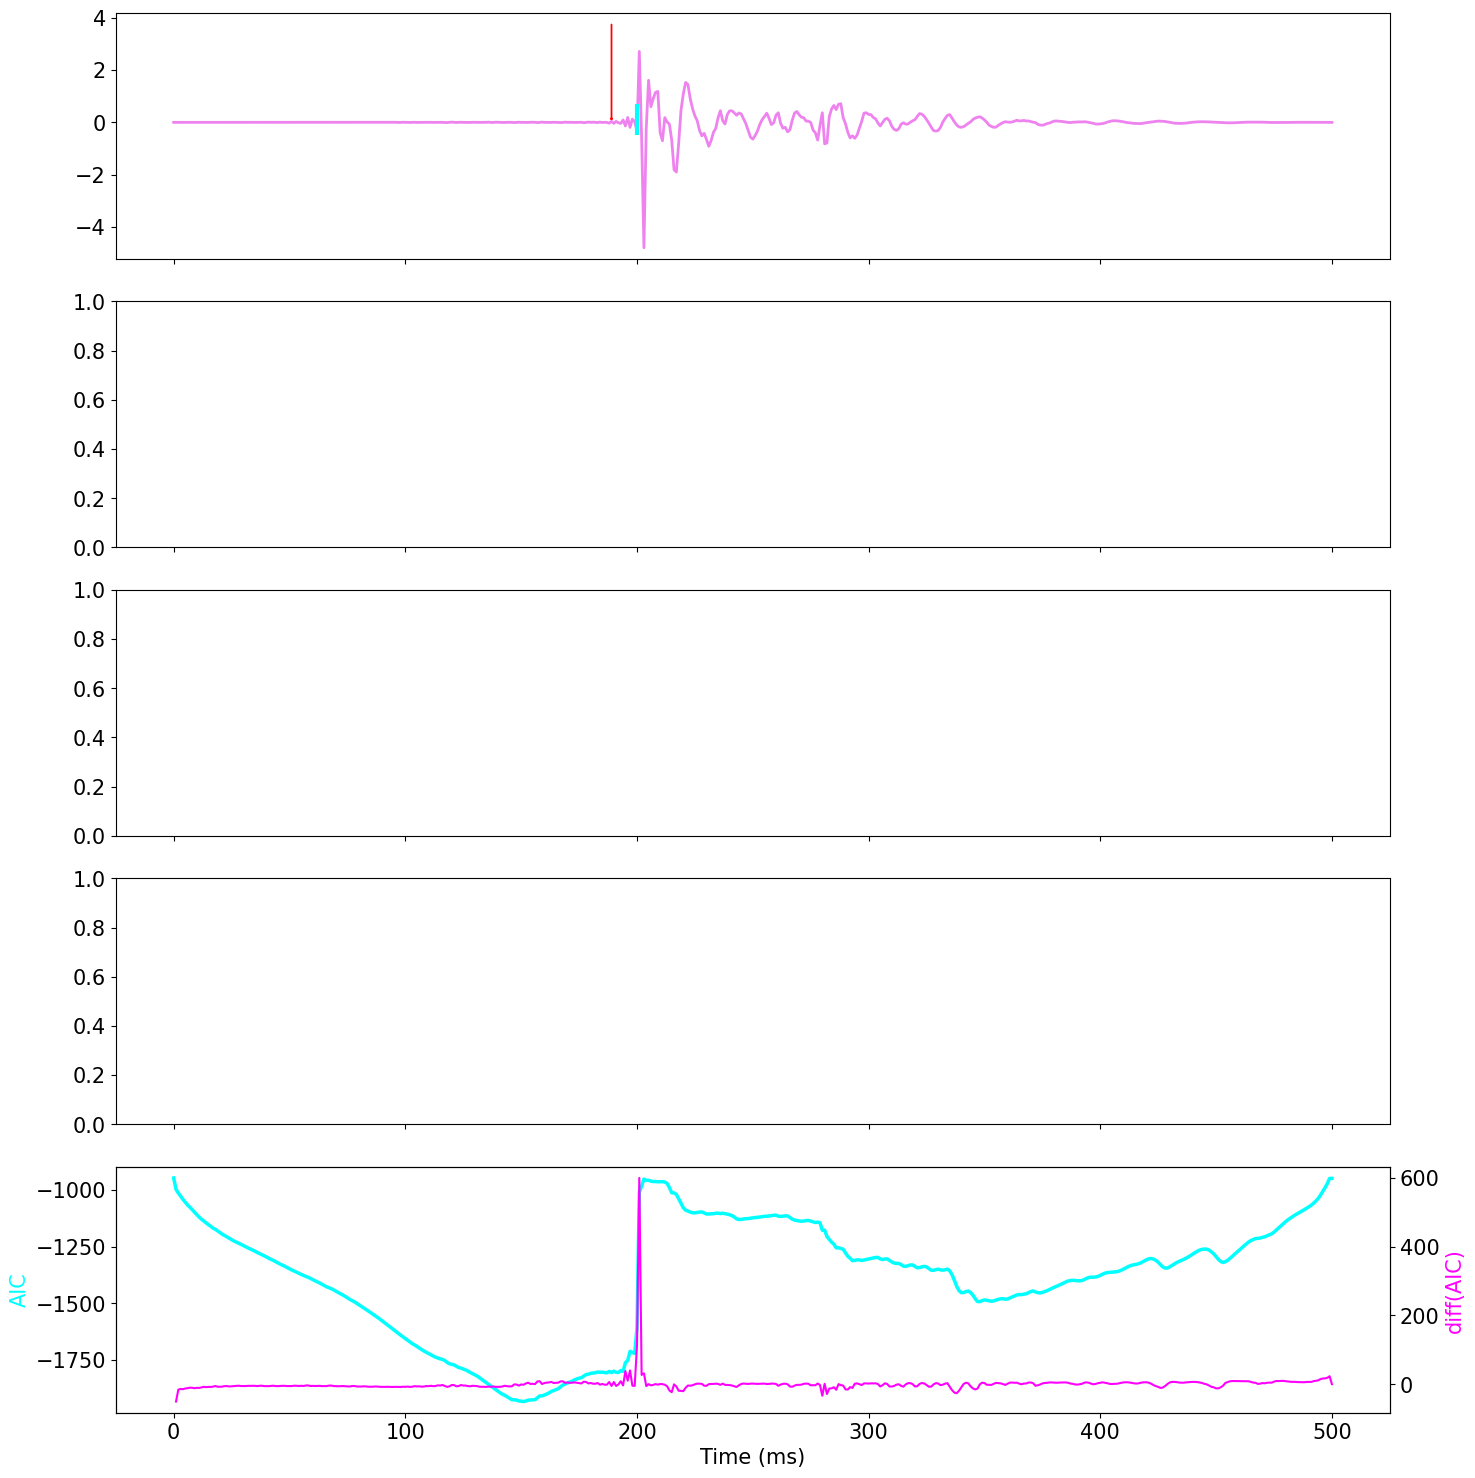

In [56]:
# plot_event(event_id=1505, day_number=141, df=df141)
event_id = 1505
ptime = 0.189
e = get_event(event_id=event_id, day_number=141, df=df141)
# def plot_event_for_p_pick(event_id, ptime):
fig, ax = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
plot_50hz_highpass(event=e, ax=ax[0])
plot_aic_pick(event=e, ax=ax[0])
ax[0].arrow(x=ptime*1e3, y=3.75, dx=0, dy=-3.6, color='red', head_width=1, head_length=0.05, label='p-arrival')


plot_aic(event=e, ax=ax[-1])
ax2 = ax[-1].twinx()
plot_aic_diff(event=e, ax=ax2)
ax[-1].set_xlabel('Time (ms)')

fig.tight_layout()

$$ v = \frac{d_{relative}}{t_{origin} - t_{p}}$$

relative depth: 12.25
origin time: 2019-05-21T08:02:31.351000Z
p velocity: 2450.0


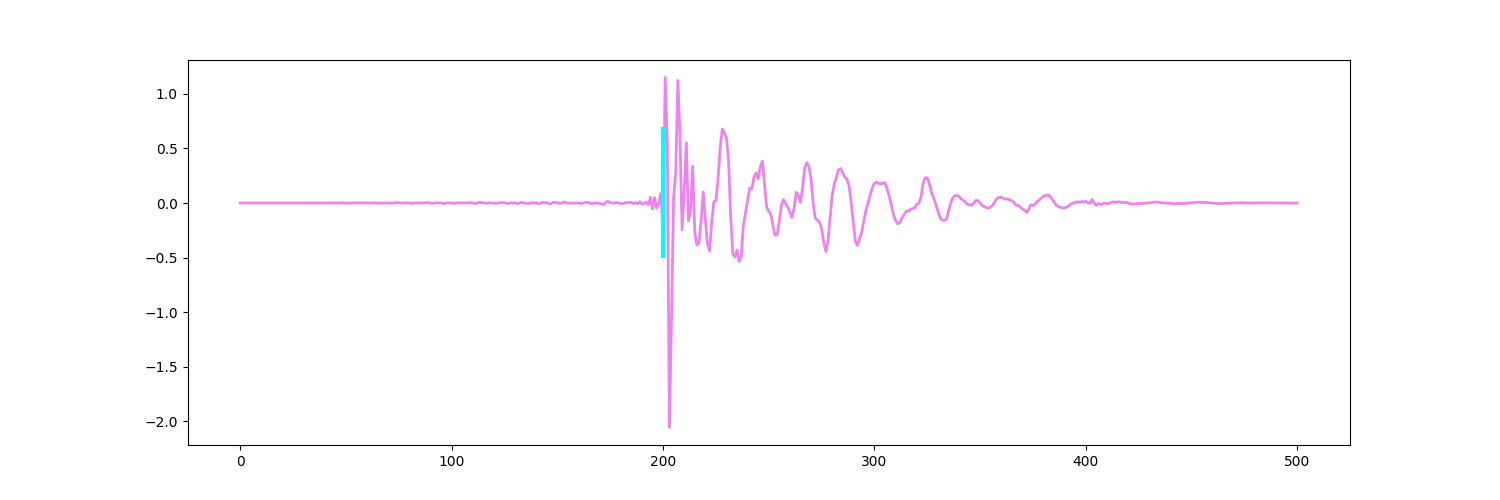

In [57]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(15, 5))


event_id = 750

e = get_event(event_id=event_id, day_number=141, df=df141)
plot_50hz_highpass(event=e, ax=ax)
plot_aic_pick(event=e,  ax=ax)

print('relative depth:', e.relative_depth)
# e.relative_depth/(obspy.UTCDateTime(df141.origin_time.loc[event_id]) - (e.starttime - 0.2) + 0.188)
print('origin time:', df141.origin_time[event_id])
print('p velocity:', e.relative_depth/(obspy.UTCDateTime(df141.origin_time[event_id]) - ((e.starttime - 0.2) + 0.188)))

relative depth: 68.25
origin time: 2019-05-21T08:18:21.829000Z
p velocity: -2527.777777777778


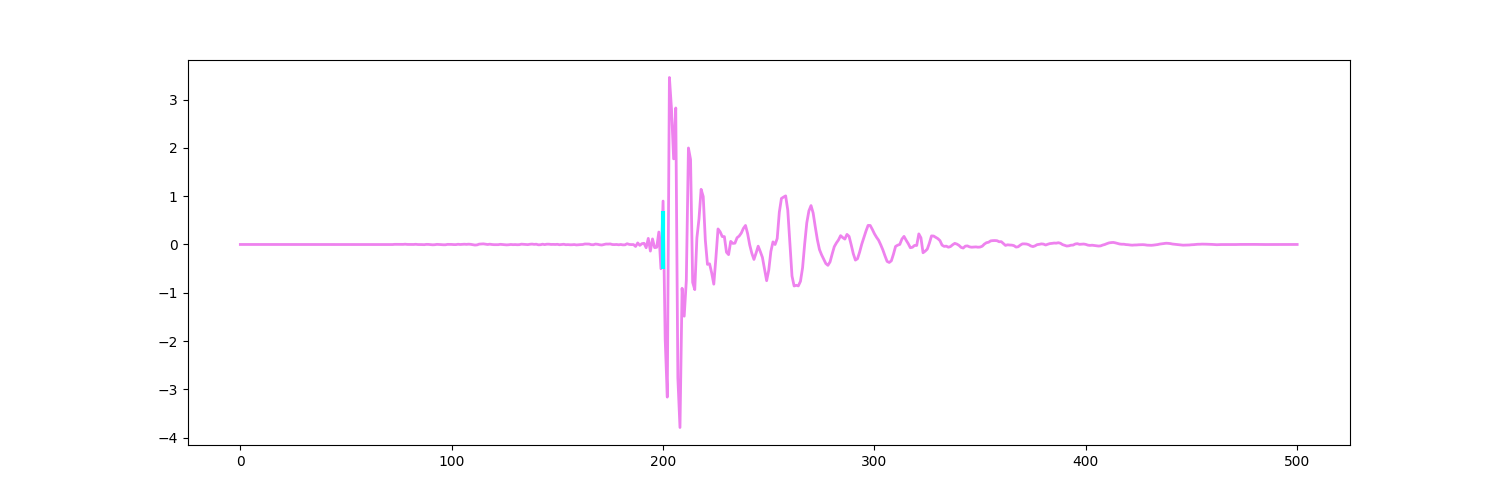

In [58]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(15, 5))


event_id = 1256

e = get_event(event_id=event_id, day_number=141, df=df141)
plot_50hz_highpass(event=e, ax=ax)
plot_aic_pick(event=e,  ax=ax)

print('relative depth:', e.relative_depth)
print('origin time:', df141.origin_time[event_id])
print('p velocity:', e.relative_depth/(obspy.UTCDateTime(df141.origin_time[event_id]) - ((e.starttime - 0.2) + 0.188)))

relative depth: 21.875
origin time: 2019-05-21T08:24:35.978500Z
p arri time: 2019-05-21T08:24:35.977000Z
p velocity: 14583.333333333332


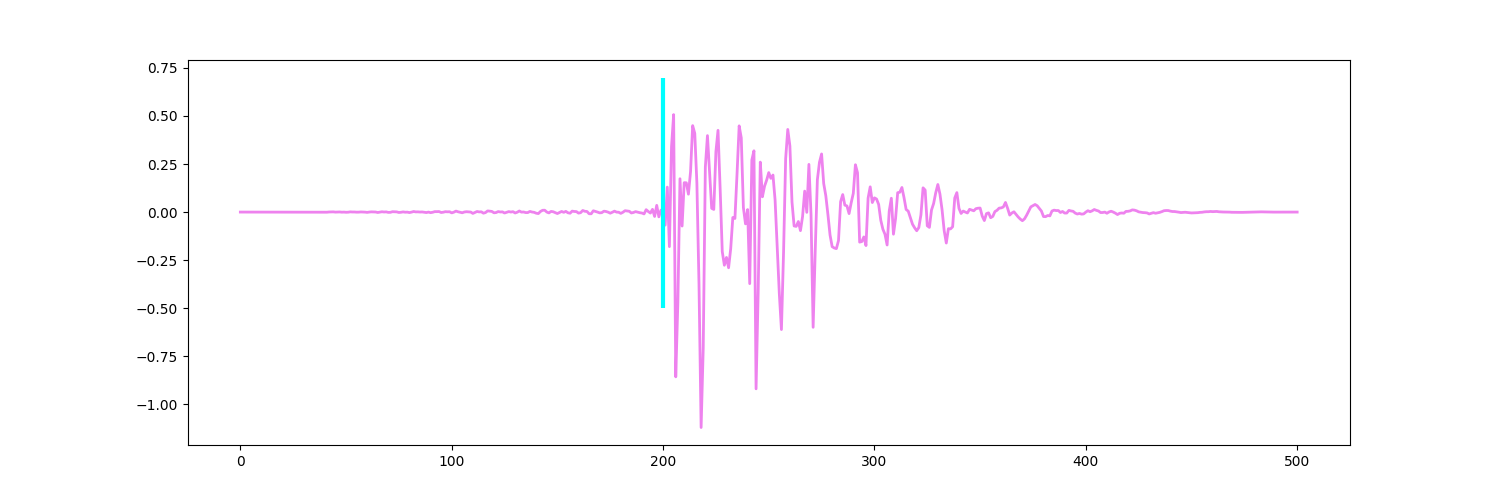

In [72]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(15, 5))


event_id = 1499

e = get_event(event_id=event_id, day_number=141, df=df141)
plot_50hz_highpass(event=e, ax=ax)
plot_aic_pick(event=e,  ax=ax)

print('relative depth:', e.relative_depth)
print('origin time:', df141.origin_time[event_id])
print('p arri time:', ((e.starttime - 0.2) + 0.188))
print('p velocity:', e.relative_depth/(obspy.UTCDateTime(df141.origin_time[event_id]) - ((e.starttime - 0.2) + 0.188)))

In [61]:
df141['id']

16        16
20        20
25        25
26        26
32        32
        ... 
2236    2236
2237    2237
2238    2238
2239    2239
2240    2240
Name: id, Length: 1931, dtype: int64

In [43]:
str(mdates.num2date(df141.arrival_time.loc[event_id]))

'2019-05-21 08:18:21.868000+00:00'

In [36]:
df141.origin_time.loc[event_id]

'2019-05-21T08:18:21.829000Z'

In [45]:
(e.starttime - 0.2) + 0.188

2019-05-21T08:18:21.856000Z

In [52]:
print('p-arrival time')
e.relative_depth/(obspy.UTCDateTime(df141.origin_time[event_id]) - ((e.starttime - 0.2) + 0.188))

p-arrival time


-2527.777777777778

In [23]:
df141.origin_time

16      2019-05-21T07:38:43.750000Z
20      2019-05-21T07:38:53.972000Z
25      2019-05-21T07:38:57.144000Z
26      2019-05-21T07:38:57.606500Z
32      2019-05-21T07:39:00.079000Z
                   ...             
2236    2019-05-21T08:37:46.246500Z
2237    2019-05-21T08:37:46.847000Z
2238    2019-05-21T08:37:47.518000Z
2239    2019-05-21T08:37:48.472500Z
2240    2019-05-21T08:37:49.325500Z
Name: origin_time, Length: 1931, dtype: object

In [20]:
e.relative_depth/(obspy.UTCDateTime(df141.origin_time.loc[event_id]) - (e.starttime - 0.2) + 0.195)

191.71348314606743

In [ ]:
obspy.UTCDateTime(dates.num2date(e.hphone1_time)) - (e.relative_depth / e.velocity_model)

In [ ]:
obspy.UTCDateTime(dates.num2date(e.hphone1_time))

In [ ]:
print('

In [ ]:
e.relative_depth

In [ ]:
e.depth

In [ ]:
# YOU NEED TO ADD THE P-WAVE PICKER

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 15), sharey=True, sharex=True)

ax[3].scatter([0], [0], s=[50*10,], alpha=0.3, color=plt.cm.twilight(0.4), label='\n Amplitude=50Pa \n')
ax[3].scatter([0], [0], s=[150*10,], alpha=0.3, color=plt.cm.twilight(0.4), label='\n Amplitude=150Pa \n')
ax[3].scatter([0], [0], s=[350*10,], alpha=0.3, color=plt.cm.twilight(0.4), label='\n Amplitude=350Pa \n')
ax[3].scatter([0], [0], s=[550*10,], alpha=0.3, color=plt.cm.twilight(0.4), label='\n Amplitude=550Pa \n')
ax[3].legend(fontsize=15, edgecolor='None')

def plot_events(data, ax):
    x = data['arrival_datetime'].diff().apply(lambda t: t.total_seconds()).fillna(0).cumsum().values
    y = data['depth'].values
    s = data['max_amp'].values
    print('amplitude:',s.max())
    print(x.max())
    # ax.scatter(x/x.max(), y, s=s*10, alpha=0.3, c=plt.cm.twilight(0.4))
    ax.scatter(x, y, s=s*10, alpha=0.3, c=plt.cm.twilight(0.4))
    return x.max()

def plot_best_fit_line(slope, intercept, ax, xstart=0, xend=1, **kwargs):
    x = np.linspace(xstart, xend, 1000)
    y = slope * x + intercept
    ax.plot(x, y, color='limegreen', linewidth=2, **kwargs)

def plot_hydrophone_depth_horizontal_line(hid, ax):
    hids = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']
    for hid in hids:
        depth = config.hydrophone_metadata_141[hid]['depth']
        ax.hlines(y=depth, xmin=-70000, xmax=700000, linestyle='--', color='black', alpha=0.25, zorder=0)

plot_hydrophone_depth_horizontal_line(hid='h3', ax=ax[0])
plot_hydrophone_depth_horizontal_line(hid='h4', ax=ax[1])
plot_hydrophone_depth_horizontal_line(hid='h5', ax=ax[2])
plot_hydrophone_depth_horizontal_line(hid='h6', ax=ax[3])
    
x141 = plot_events(data=df141, ax=ax[0])
# x188 = plot_events(data=df188, ax=ax[1])
# x197 = plot_events(data=df197, ax=ax[2])
# x211 = plot_events(data=df211, ax=ax[3])

plot_best_fit_line(slope=0.059, intercept=165
                   , ax=ax[0], xstart=0, xend=x141
                  , label=r'$y = 0.059 x + 165$')

# plot_best_fit_line(slope=0.071, intercept=115
#                    , ax=ax[1], xstart=0.2*x188, xend=0.8*x188
#                   , label=r'$y = 0.071 x + 115$')

# plot_best_fit_line(slope=0.069, intercept=100
#                    , ax=ax[1], xstart=1000, xend=4100
#                   ,linestyle='--', label=r'$y = 0.069x + 100$')

# plot_best_fit_line(slope=0.064, intercept=85
#                    , ax=ax[1], xstart=0.3*x188, xend=1*x188
#                   ,linestyle='-.', label=r'$y = 0.064x + 85$')

# plot_best_fit_line(slope=0.1, intercept=150
#                    , ax=ax[2], xstart=250, xend=2000
#                   ,label=r'$0.1 x + 150$')

# plot_best_fit_line(slope=0.066, intercept=-17
#                    , ax=ax[2], xstart=2800, xend=6000
#                   ,linestyle='--', label=r'$y = 0.066 x - 17$')

# plot_best_fit_line(slope=0.2, intercept=80
#                    , ax=ax[3], xstart=400, xend=1581
#                   ,label=r'$y = 0.2 x + 85$')

ax[0].set_yticks(np.arange(150, 425, 25))
ax[0].set_yticklabels(np.arange(150, 425, 25), fontsize=15)
ax[0].set_ylim(400, 150)
ax[0].set_xlim(-100, 6750)
fig.tight_layout()
ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)
ax[2].legend(fontsize=15)
ax[3].legend(fontsize=15)

# fig.savefig('figures/events.pdf')

In [ ]:
# (e.starttime._get_datetime().replace(tzinfo=datetime.timezone.utc) - e.parrival).total_seconds()

In [ ]:
# e.first_hydrophone_id

In [ ]:
# dates.num2date(e.aic_t[4])

In [ ]:
# e.starttime._get_datetime()